# Rotate vols and FSC

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.algorithm import *
from src.ab_initio import *
from src.datasets import *
from src.residual import get_volume_residual

import jax
import mrcfile
from jax.scipy.special import gammaln
from tqdm import tqdm

plt.rcParams["figure.figsize"]=6,6

### Load the volumes

In [4]:
#file1 = "/gpfs/loomis/project/lederman/bt387/simple_cryoem/simulated_dataset10k/vol1_84.mrc"
#file2 = "/gpfs/loomis/project/lederman/bt387/simple_cryoem/simulated_dataset_results10k/relion_noisy/rec_iter_176.mrc"
#nx0 = 256
#pixel_size = 1.244531

#file1 = "/gpfs/loomis/project/lederman/bt387/simple_cryoem/simulated_dataset10k/vol2_84.mrc"
#file2 = "/gpfs/loomis/project/lederman/bt387/simple_cryoem/simulated_dataset_results10k/cryodrgn_noisy/rec_iter_176.mrc"
#file2 = "/gpfs/gibbs/pi/lederman/bt387/simulated_dataset10k/cryodrgn_clean/InitialModel/job001/run_it120_class001.mrc"
#nx0 = 320
#pixel_size = 1.31

#file1 = "/gpfs/gibbs/pi/lederman/bt387/exp_data/output_simple_cryoem1v/rec_iter_155.mrc"
#file2 = "/gpfs/gibbs/pi/lederman/bt387/exp_data/output_simple_cryoem2v/rec_iter_155.mrc"
#nx0 = 320
#pixel_size = 1.31

file1 = "/gpfs/gibbs/pi/lederman/bt387/exp_data/InitialModel/particles1_corrected/run_it300_class001.mrc"
file2 = "/gpfs/gibbs/pi/lederman/bt387/exp_data/InitialModel/particles2_corected/run_it300_class001.mrc"
nx0 = 320
pixel_size = 1.31

vol1 = mrcfile.open(file1).data
vol2 = mrcfile.open(file2).data

vol1_f, _, _ = volume_fourier(vol1, pixel_size)
vol2_f, _, _ = volume_fourier(vol2, pixel_size)

In [9]:
print(f"vol1_f.shape = {vol1_f.shape}")
print(f"vol2_f.shape = {vol2_f.shape}")

vol1_f.shape = (84, 84, 84)
vol2_f.shape = (84, 84, 84)


In [5]:
nx = jnp.minimum(vol1_f.shape[0], vol2_f.shape[0])
grid1 = [1, vol1_f.shape[0]]
grid2 = [1, vol2_f.shape[0]]

In [8]:
vol1_f, _ = crop_fourier_volume(vol1_f, grid1, nx)
vol2_f, grid = crop_fourier_volume(vol2_f, grid2, nx)

In [10]:
print(f"vol1_f.shape = {vol1_f.shape}")
print(f"vol2_f.shape = {vol2_f.shape}")

vol1_f.shape = (84, 84, 84)
vol2_f.shape = (84, 84, 84)


In [11]:
res, fsc, shell_points = calc_fsc(vol1_f, vol2_f, grid)

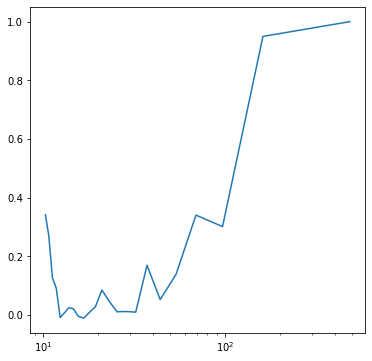

In [12]:
res_angs = nx0 * pixel_size/res
plt.semilogx(res_angs, fsc)

In [13]:
res

DeviceArray([ 0.8660254 ,  2.59807621,  4.33012702,  6.06217783,
              7.79422863,  9.52627944, 11.25833025, 12.99038106,
             14.72243186, 16.45448267, 18.18653348, 19.91858429,
             21.65063509, 23.3826859 , 25.11473671, 26.84678752,
             28.57883832, 30.31088913, 32.04293994, 33.77499075,
             35.50704156, 37.23909236, 38.97114317, 40.70319398],            dtype=float64)

In [14]:
res_angs

DeviceArray([484.05046569, 161.35015523,  96.81009314,  69.15006653,
              53.78338508,  44.00458779,  37.23465121,  32.27003105,
              28.47355681,  25.4763403 ,  23.05002218,  21.04567242,
              19.36201863,  17.92779503,  16.69139537,  15.61453115,
              14.66819593,  13.83001331,  13.08244502,  12.4115504 ,
              11.80610892,  11.25698757,  10.75667702,  10.29894608],            dtype=float64)

In [15]:
@jax.jit
def calc_corr(v1, v2):
    corr = jnp.sum(v1 * jnp.conj(v2)) / (jnp.linalg.norm(v1.ravel(),2) * jnp.linalg.norm(v2.ravel(),2))
    return jnp.real(corr)

@jax.jit
def rotate_and_calc_corr(v1, v2, angles0, angles_i):

    vol1_r = rotate_and_interpolate_full_object(v1, angles0, grid) 
    vol2_r = rotate_and_interpolate_full_object(v2, angles_i, grid) 
    
    return calc_corr(vol1_r, vol2_r)

rotate_and_calc_corr_vmap = jax.jit(jax.vmap(rotate_and_calc_corr, in_axes=(None, None, None, 0)))

#@jax.jit
def rotate_and_interpolate_full_object(vol, angles, grid):
    proj_coords = rotate_full_grid(grid, angles)
    return interpolate(proj_coords, grid, vol, "tri")


In [16]:
N = 30

a1_range = np.linspace(0, 2*jnp.pi, N)
a2_range = np.linspace(0, jnp.pi, N)
a3_range = np.linspace(0, 2*jnp.pi, N)

A1, A2, A3 = np.meshgrid(a1_range, a2_range, a3_range)  

angles = np.column_stack([A1.ravel(), A2.ravel(), A3.ravel()])
angles0 = np.array([0,0,0])

grid = np.array(grid)
vol1_f = jnp.array(vol1_f)
vol2_f = jnp.array(vol2_f)

In [53]:
# CHANGE CHIRALITY IF NEEDED!!

vol2_f = jnp.flip(vol2_f, axis=2)

In [54]:
N_batch = 1000
angles_batch = np.array(np.array_split(angles, N_batch))

corrs_batch = []
for bi in tqdm(np.arange(N_batch)):
    corr_i = rotate_and_calc_corr_vmap(vol1_f, vol2_f, jnp.array(angles0), jnp.array(angles_batch[bi]))
    corrs_batch.append(corr_i)
    
corrs = np.concatenate(corrs_batch, axis=0)

100%|██████████| 1000/1000 [01:35<00:00, 10.48it/s]


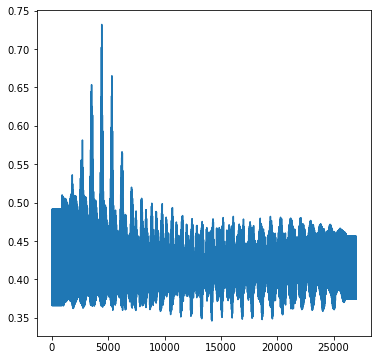

In [55]:
plt.plot(corrs)

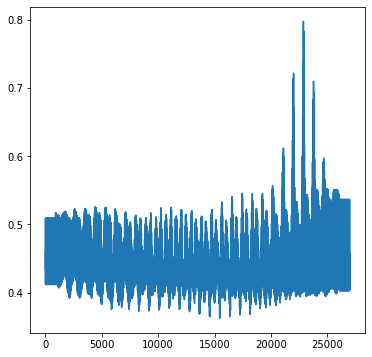

In [41]:
plt.plot(corrs)

In [56]:
print(f"max corr = {jnp.max(corrs)}")
max_idx = jnp.argmax(corrs)
angles_good = angles[max_idx]

vol2_fr = rotate_and_interpolate_full_object(vol2_f, angles_good, grid)
vol2_fr = vol2_fr.reshape([nx,nx,nx])

max corr = 0.7318246235339172


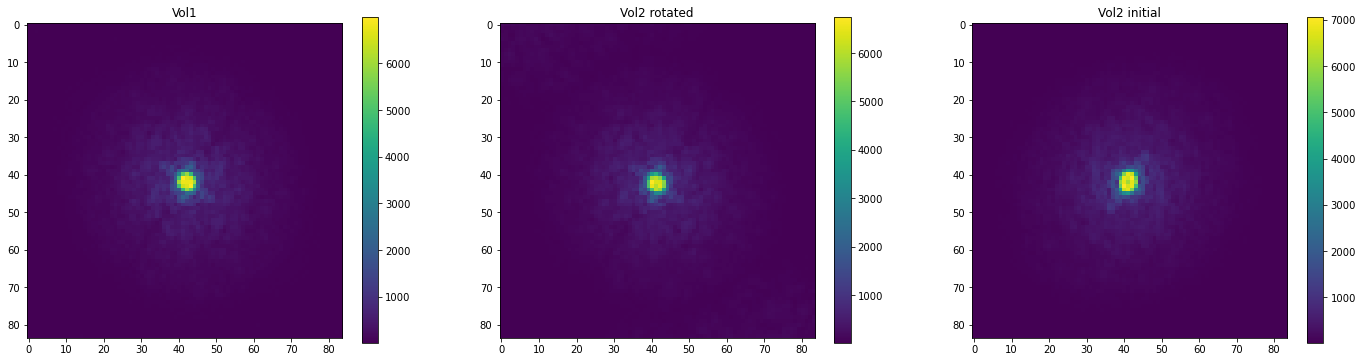

In [57]:
plt.rcParams["figure.figsize"]=24,6

plt.subplot(1,3,1)
mip_x(jnp.abs(jnp.fft.fftshift(vol1_f))); plt.colorbar()
plt.title("Vol1")

plt.subplot(1,3,2)
mip_x(jnp.abs(jnp.fft.fftshift(vol2_fr))); plt.colorbar()
plt.title("Vol2 rotated")


plt.subplot(1,3,3)
mip_x(jnp.abs(jnp.fft.fftshift(vol2_f))); plt.colorbar()
plt.title("Vol2 initial")

plt.rcParams["figure.figsize"]=6,6

In [58]:
res, fsc, shell_points = calc_fsc(vol1_f, vol2_fr, grid)

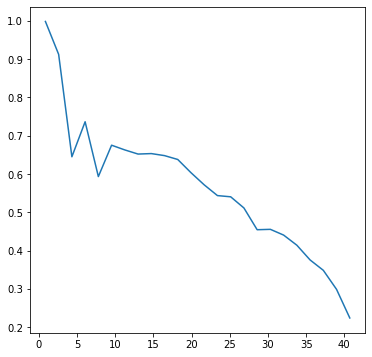

In [59]:
plt.plot(res, fsc)

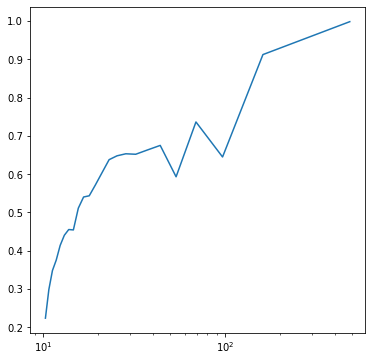

In [60]:
res_angs = nx0 * pixel_size/res
plt.semilogx(res_angs, fsc)

In [61]:
res_angs

DeviceArray([484.05046569, 161.35015523,  96.81009314,  69.15006653,
              53.78338508,  44.00458779,  37.23465121,  32.27003105,
              28.47355681,  25.4763403 ,  23.05002218,  21.04567242,
              19.36201863,  17.92779503,  16.69139537,  15.61453115,
              14.66819593,  13.83001331,  13.08244502,  12.4115504 ,
              11.80610892,  11.25698757,  10.75667702,  10.29894608],            dtype=float64)

In [62]:
fsc

DeviceArray([0.99825011, 0.91228567, 0.64487679, 0.73634352, 0.59314278,
             0.67507506, 0.66275694, 0.65195443, 0.65320357, 0.64789041,
             0.63782022, 0.6032793 , 0.57150826, 0.54349046, 0.54031976,
             0.51118516, 0.45434567, 0.45534807, 0.44035084, 0.4139212 ,
             0.37543002, 0.34832491, 0.29860307, 0.2238669 ],            dtype=float64)

In [29]:
nx0 * pixel_size/42

9.980952380952383

In [30]:
pixel_size

1.31

In [31]:
nx0

320

### Orientation errors for the simulated data

In [ ]:
dataset = "cryodrgn_noisy"

In [ ]:
data_dir = f"/gpfs/loomis/project/lederman/bt387/simple_cryoem/simulated_dataset10k/{dataset}/"
star_file = "particles.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = False, fourier = False)
ctf_params0 = params0["ctf_params"]
pixel_size0 = params0["pixel_size"]
angles0 = params0["angles"]
shifts0 = params0["shifts"]

In [ ]:
with open(f"/gpfs/loomis/project/lederman/bt387/simple_cryoem/simulated_dataset_results10k/{dataset}/rec_iter_176_angles", 'rb') as file:
    # Call load method to deserialze
    angles_rec = pickle.load(file)
    
angles_rec = angles_rec[0]

In [ ]:
angles0.shape

In [ ]:
angles_rec.shape

In [ ]:
theta, cord_distance = err_orientations(angles0, angles_rec)


In [ ]:
nbins=100
counts, bins = np.histogram((theta - jnp.median(theta))**2, bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

In [ ]:
nbins = 100
counts, bins = np.histogram((cord_distance - jnp.median(cord_distance))**2, bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

In [ ]:
jnp.max(bins)

In [ ]:
jnp.median(cord_distance)

In [ ]:
jnp.median((cord_distance - jnp.median(cord_distance))**2)

In [ ]:
cord_distance

In [ ]:
plt.plot(jnp.sort((cord_distance - jnp.median(cord_distance))**2))

### Misc

In [ ]:
file1 = "/gpfs/gibbs/pi/lederman/bt387/exp_data/output_simple_cryoem1v/rec_iter_150.mrc"
#file1 = "/gpfs/gibbs/pi/lederman/bt387/simulated_dataset10k/relion_clean/InitialModel/job001/run_it300_class001.mrc"

nx0 = 320
pixel_size = 1.31

vol1 = mrcfile.open(file1).data

vol1_f, _, _ = volume_fourier(vol1, pixel_size)

In [ ]:
grid = [1, vol1_f.shape[0]]
vol_fc, _ = rescale_larger_grid(vol1_f, grid, 320)
vol_rc = np.real(np.fft.fftshift(np.fft.ifftn(vol_fc)))


In [ ]:
mip_x(vol_rc)

In [ ]:
vol_rc = jnp.flip(vol_rc, axis=0)

In [ ]:
#with mrcfile.new(f"/gpfs/gibbs/pi/lederman/bt387/exp_data/vol2_test10.mrc", overwrite=True) as mrc:
#    mrc.set_data(vol_rc.astype(np.float32))